##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

This notebook is used to generate musical notes using a simple recurrent neural network (RNN) as a melodic base for further processing by the rhythmizer and harmonizer. We will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, our model will learn to predict the next note in the sequence. We generate longer sequences of notes by calling the model repeatedly.

## Setup

We use the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [2]:
import collections
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf


from matplotlib import pyplot as plt
from typing import Optional

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

tf.device(device_name)

SystemError: GPU device not found

In [4]:
seed = 45732
tf.random.set_seed(seed)
np.random.seed(seed)

## Download the Maestro dataset

In [5]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

The dataset contains about 1,200 MIDI files.

In [6]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.


Extract the notes.

In [7]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [8]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

Check the distribution of each note variable.

In [9]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [10]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

## Create the training dataset

Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [11]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [12]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 37241


Next, create a `tf.data.Dataset` from the parsed notes.

In [13]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [14]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

We train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence.

We use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [15]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [16]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [17]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5546875  0.         0.096875  ]
 [0.4296875  0.18645833 0.21770833]
 [0.5546875  0.009375   0.50520833]
 [0.4609375  0.175      0.16770833]
 [0.484375   0.16979167 0.11979167]
 [0.5625     0.153125   0.04166667]
 [0.5234375  0.01666667 0.196875  ]
 [0.578125   0.18020833 0.11458333]
 [0.4453125  0.         0.53958333]
 [0.5625     0.05416667 0.06875   ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=59.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.008333333333333304>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.15937500000000027>}


*Batch* the examples, and configure the dataset for performance.

In [18]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [19]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [20]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [21]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128, return_sequences=False)(inputs)


outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses.
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [22]:
losses = model.evaluate(train_ds, return_dict=True)
losses

581/581 [==============================] - 9s 8ms/step - loss: 5.7814 - duration_loss: 0.1182 - pitch_loss: 4.8569 - step_loss: 0.8063


{'loss': 5.781399726867676,
 'duration_loss': 0.11821672320365906,
 'pitch_loss': 4.8568830490112305,
 'step_loss': 0.8062965273857117}

[Linktext](https://)One way balance this is to use the `loss_weights` argument to compile:

In [23]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration': 1.0
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [24]:
model.evaluate(train_ds, return_dict=True)

581/581 [==============================] - 6s 8ms/step - loss: 1.1674 - duration_loss: 0.1182 - pitch_loss: 4.8569 - step_loss: 0.8063


{'loss': 1.1673564910888672,
 'duration_loss': 0.11821672320365906,
 'pitch_loss': 4.8568830490112305,
 'step_loss': 0.8062965273857117}

Train the model.

In [25]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=10,
        verbose=1,
        restore_best_weights=True),
]

In [26]:
%%time
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
581/581 [==============================] - 13s 17ms/step - loss: 0.3229 - duration_loss: 0.0845 - pitch_loss: 4.0165 - step_loss: 0.0376
Epoch 2/100
581/581 [==============================] - 9s 15ms/step - loss: 0.3131 - duration_loss: 0.0828 - pitch_loss: 3.9150 - step_loss: 0.0345
Epoch 3/100
581/581 [==============================] - 9s 15ms/step - loss: 0.3088 - duration_loss: 0.0806 - pitch_loss: 3.8874 - step_loss: 0.0338
Epoch 4/100
581/581 [==============================] - 9s 15ms/step - loss: 0.3075 - duration_loss: 0.0803 - pitch_loss: 3.8718 - step_loss: 0.0337
Epoch 5/100
581/581 [==============================] - 9s 15ms/step - loss: 0.3038 - duration_loss: 0.0791 - pitch_loss: 3.8265 - step_loss: 0.0333
Epoch 6/100
581/581 [==============================] - 9s 16ms/step - loss: 0.3022 - duration_loss: 0.0786 - pitch_loss: 3.8101 - step_loss: 0.0332
Epoch 7/100
581/581 [==============================] - 8s 15ms/step - loss: 0.3004 - duration_loss: 0.0775 - pi

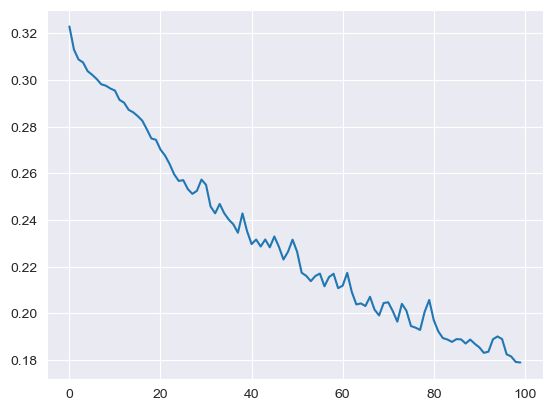

In [27]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, we first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated.

In [28]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [29]:
temperature = 4.0
num_predictions = 240*8

sample_file = filenames[1]
raw_notes = midi_to_notes(sample_file)
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 30ms/step


In [30]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,74,2.173828,0.188718,2.173828,2.362546
1,88,0.449901,1.165345,2.623729,3.789075
2,84,0.470694,1.273680,3.094423,4.368104
3,82,0.472962,1.232907,3.567386,4.800293
4,88,0.477600,1.208471,4.044986,5.253457
5,53,0.471249,1.176162,4.516235,5.692397
6,82,0.467056,1.181750,4.983291,6.165041
7,90,0.475244,1.216023,5.458536,6.674558
8,80,0.480413,1.277184,5.938949,7.216133
9,88,0.451576,1.090163,6.390525,7.480688


In [31]:
out_file = 'synthesized.mid'
pm = pretty_midi.PrettyMIDI(sample_file)
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)